# A Data Science Business Case: Predictive Modeling for Increasing Website Traffic
#### by [Ali Denewade](https://www.datacamp.com/certificate/DS0025541624864)

## Introduction

In this Notebook, I will present a solution to the problem of predicting popular recipes at Tasty Bytes, as requested by the Product Manager and instructed by the Head of Data Science. The goal is to increase traffic and subscriptions by correctly predicting high-traffic recipes 80% of the time. I will provide a written report that includes data analysis, model development, evaluation, and final recommendations for the business.

## Executive Summary

The project aims to predict high traffic recipes on the recipe website Tasty Bytes in order to increase traffic and subscriptions. I performed an analysis using supervised machine learning classification techniques and found that the final models used, Extra Trees and Random Forest, had an accuracy of 0.8401 and 0.8394 respectively. It is important that the model's performance is monitored by tracking key metrics such as accuracy, AUC, F1-score, precision, recall, Kappa and Cross Validation score, all of which should be at least 0.8. This will ensure that the model is correctly predicting high traffic recipes and minimizing the chance of showing unpopular recipes.

_Please note that validation scores may fluctuate as re-running the model may generate different augmented data compared to the initial augmentation._

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

# **DATA VALIDATION**



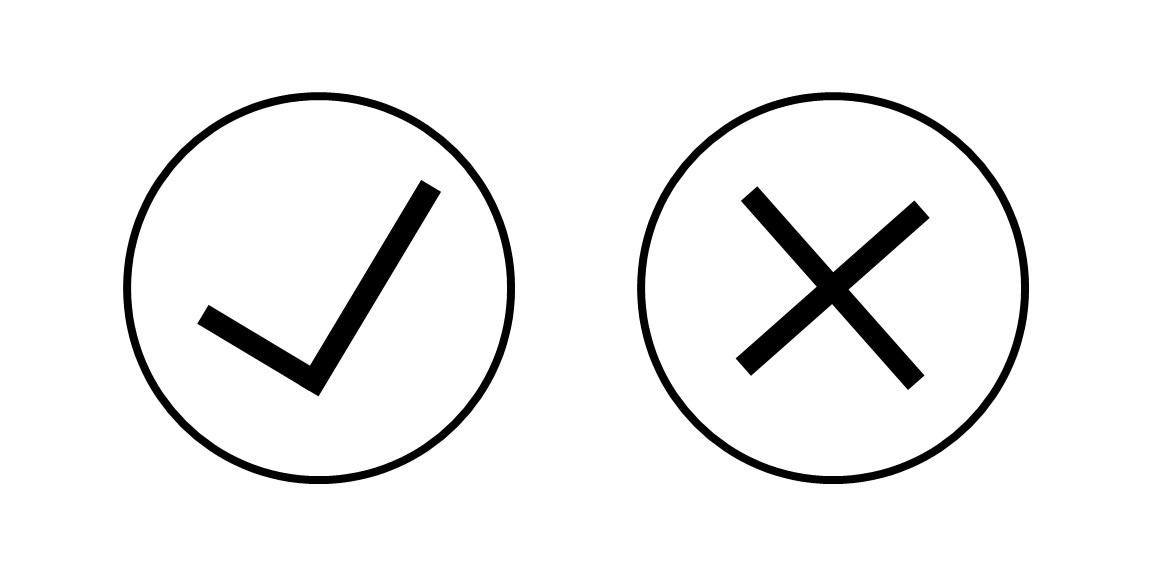

## Summary for Data Validation

1. Calculated the mean values for each ingredient column and filled the empty cells with their respective mean values.
2. Merged the information for snacks and lunch into the 'servings' column.
3. Converted the values in the 'calories' column to grams.
4. Replaced the empty cells in the 'high_traffic' column with the value "Low" to make it binary.

The following table is the updated Data Dictionary:

In [2]:
import pandas as pd

data = {'Variable': ['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings', 'high_traffic'],
        'Data Type': ['float64', 'float64', 'float64', 'float64', 'object', 'int64', 'object'],
        'Details': ['(0.01814372, 470.85026968) in grams', '(0.03, 530.42) in grams', '(0.01, 148.75) in grams', '(0, 363.36) in grams', 'Pork, Potato, Breakfast, Beverages, One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, Vegetable, Meat', '1, 2, 3, 4, 6', 'High, Low']}

df = pd.DataFrame(data)

df


,Variable,Data Type,Details
0,calories,float64,"(0.01814372, 470.85026968) in grams"
1,carbohydrate,float64,"(0.03, 530.42) in grams"
2,sugar,float64,"(0.01, 148.75) in grams"
3,protein,float64,"(0, 363.36) in grams"
4,category,object,"Pork, Potato, Breakfast, Beverages, One Dish M..."
5,servings,int64,"1, 2, 3, 4, 6"
6,high_traffic,object,"High, Low"


Following are the codes for this section.

In [3]:
# Load the data drop recipe
df = pd.read_csv('recipe_site_traffic_2212.csv')

df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


Examine Null Values

In [4]:
# check if there are any NaN values in the dataframe
pd.DataFrame(df.isnull().sum())

,0
recipe,0
calories,52
carbohydrate,52
sugar,52
protein,52
category,0
servings,0
high_traffic,373


In [5]:
# drop recipe column
df.drop('recipe', axis=1, inplace=True)
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,NaN


List of Categories

In [6]:
# check unique values in the category column
pd.DataFrame(df['category'].unique())

,0
0,Pork
1,Potato
2,Breakfast
3,Beverages
4,One Dish Meal
5,Chicken Breast
6,Lunch/Snacks
7,Chicken
8,Vegetable
9,Meat


Here we replaced all the NaN values of the column calories, carbohydrate, sugar and protein with the mean of the column. The table below shows that the only column with NaN is `high_traffic`.

In [7]:
# write a loop that will replace all the NaN values of the column calories, carbohydrate, sugar and protein with the mean of the column
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col].fillna(df[col].mean(), inplace=True)

# check if there are any NaN values in the dataframe
pd.DataFrame(df.isnull().sum())

,0
calories,0
carbohydrate,0
sugar,0
protein,0
category,0
servings,0
high_traffic,373


The conversion of Calories to Grams was done according to [Inch Calculator](https://www.inchcalculator.com/convert/calorie-burned-to-gram/#:~:text=To%20convert%20a%20calorie%20measurement,weight%20by%20the%20conversion%20ratio.&text=The%20weight%20in%20grams%20is%20equal%20to%20the%20calories%20multiplied%20by%200.129598.).

In [8]:
# convert calories to grams by multiplying by 0.129598
df['calories'] = df['calories']*0.129598

In [9]:
# check the unique values in the servings column
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [10]:
# replace the '4 as a snack' with 4 and '6 as a snack' with 6
df['servings'].replace({'4 as a snack': 4, '6 as a snack': 6}, inplace=True)
# check the unique values in the servings column
df['servings'].unique()

array(['6', '4', '1', '2', 4, 6], dtype=object)

In [11]:
# convert the servings column to integer
df['servings'] = df['servings'].astype(int)

In [12]:
# check unique value the high_traffic column
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [13]:
# replace NaN with 'Low' in the high_traffic column
df['high_traffic'].fillna('Low', inplace=True)

# check unique value the high_traffic column
df['high_traffic'].unique()

array(['High', 'Low'], dtype=object)

In [14]:
# describe data
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,56.496848,35.069676,9.046547,24.149296,3.477297
std,57.074199,42.724059,14.270029,35.356020,1.732741
min,0.018144,0.030000,0.010000,0.000000,1.000000
25%,14.827307,9.135000,1.795000,3.465000,2.000000
50%,40.632861,23.170000,5.050000,12.120000,4.000000
75%,74.677608,42.590000,9.285000,28.530000,4.000000
max,470.850270,530.420000,148.750000,363.360000,6.000000


In [15]:
# Check data types
pd.DataFrame(df.dtypes)

,0
calories,float64
carbohydrate,float64
sugar,float64
protein,float64
category,object
servings,int64
high_traffic,object


In [16]:
# create a loop to normalize the columns with types float64
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())

# check head of the dataframe
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,0.119955,0.066064,0.060754,0.066461,Pork,6,High
1,0.009727,0.072645,0.004370,0.002532,Potato,4,High
2,0.251620,0.080413,0.020707,0.007926,Breakfast,1,Low
3,0.026669,0.057561,0.259648,0.000055,Beverages,4,High
4,0.007407,0.003431,0.005311,0.001459,Beverages,4,Low


# 🔍 **EXPLORATORY ANALYSIS**

## Summary for Exploraory ANalysis

1. Created a donut plot for the first single variable graphic.
2. Created a bar plot for the second single variable graphic.
3. Created a box plot for the first multiple variable graphic.
4. Created a bar plot for the second multiple variable graphic.

## Description of my findings
1. The data suggests that calories are the main nutrient presented in Tasty Bytes' offerings.
2. There is a notable presence of outliers in the ingredient data.
3. Sugar is a less prevalent ingredient in Tasty Bytes' products.
4. Breakfast, Chicken Breasts, and Beverages are the most popular categories of Tasty Bytes' offerings.
5. The most frequently chosen serving size among Tasty Bytes' customers appears to be 4.

Based on these findings, it seems that Tasty Bytes places a strong emphasis on providing calorie information and offering balanced meal options. The top categories of products are breakfast items, chicken breasts, and beverages. Additionally, customers tend to prefer servings of 4.

## Graphic 1 (Single variables only)

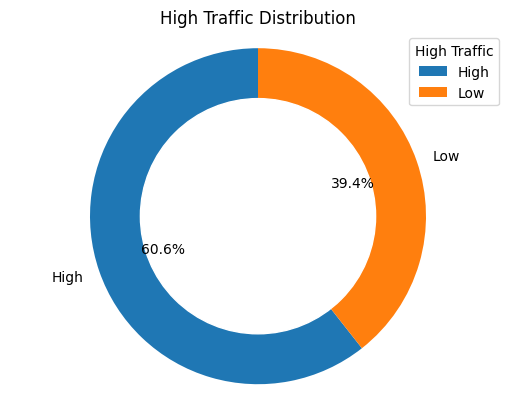

In [17]:

high_traffic_counts = df['high_traffic'].value_counts()

fig, ax = plt.subplots()
ax.pie(high_traffic_counts, labels=high_traffic_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title("High Traffic Distribution")

# Create a circle to make the donut chart
circle = plt.Circle((0,0), 0.7, color='white')

# Add the circle to the plot
ax.add_artist(circle)

plt.legend(title = 'High Traffic')
plt.show()

## Graphic 2 (Single variables only)

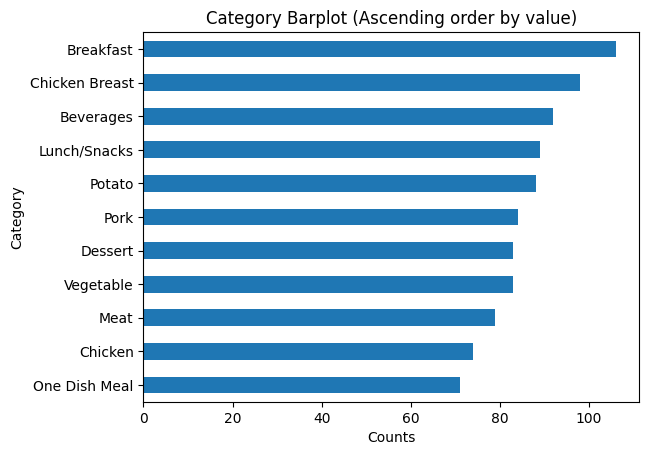

In [18]:
# draw barplot of the category column in ascending order
df['category'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('Category')
plt.title("Category Barplot (Ascending order by value)")
plt.show()

##  Graphic 1 (Showing two or more variables)

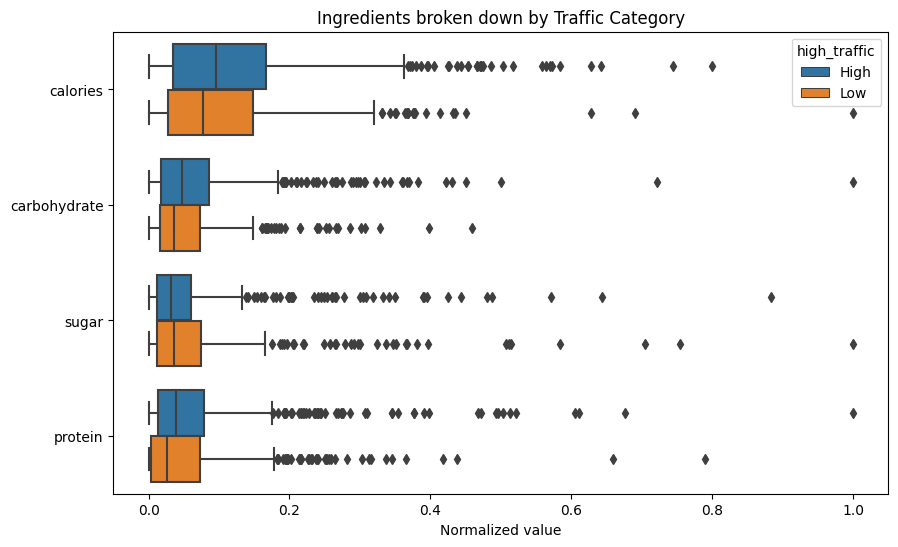

In [19]:
# Creating a figure object
fig = plt.figure()

# Melting the dataframe to reshape it for visualizing using seaborn
df_melt = pd.melt(df, id_vars=['high_traffic'], value_vars=['calories', 'carbohydrate', 'sugar', 'protein'], value_name='value')

# Creating a boxplot using seaborn
sns.boxplot(x='value', y='variable', hue='high_traffic', data=df_melt)

# Labeling the x-axis
plt.xlabel('Normalized value')

# Labeling the y-axis
plt.ylabel('')

# Adding a title to the plot
plt.title("Ingredients broken down by Traffic Category")

# Setting the size of the figure
fig.set_size_inches(10, 6)


##  Graphic 2 (Showing two or more variables)

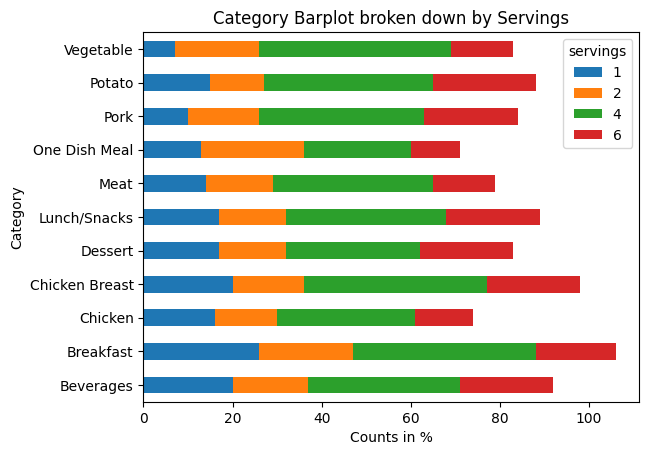

In [20]:
# Grouping the dataframe by 'category' and 'servings' columns
# and counting the number of items in each group
grouped_df = df.groupby(['category', 'servings']).size()

# Reshaping the resulting dataframe using the unstack() method
unstacked_df = grouped_df.unstack()

# Sorting the index in ascending order
unstacked_df.sort_index(ascending=True)

# Plotting the resulting dataframe as a stacked horizontal bar plot
unstacked_df.plot(kind='barh', stacked=True)

# Labeling the x-axis
plt.xlabel('Counts in %')

# Labeling the y-axis
plt.ylabel('Category')

# Adding a title to the plot
plt.title("Category Barplot broken down by Servings")

# Displaying the plot
plt.show()

# 🛠️  Further Preprocessing
## Feature Engineering

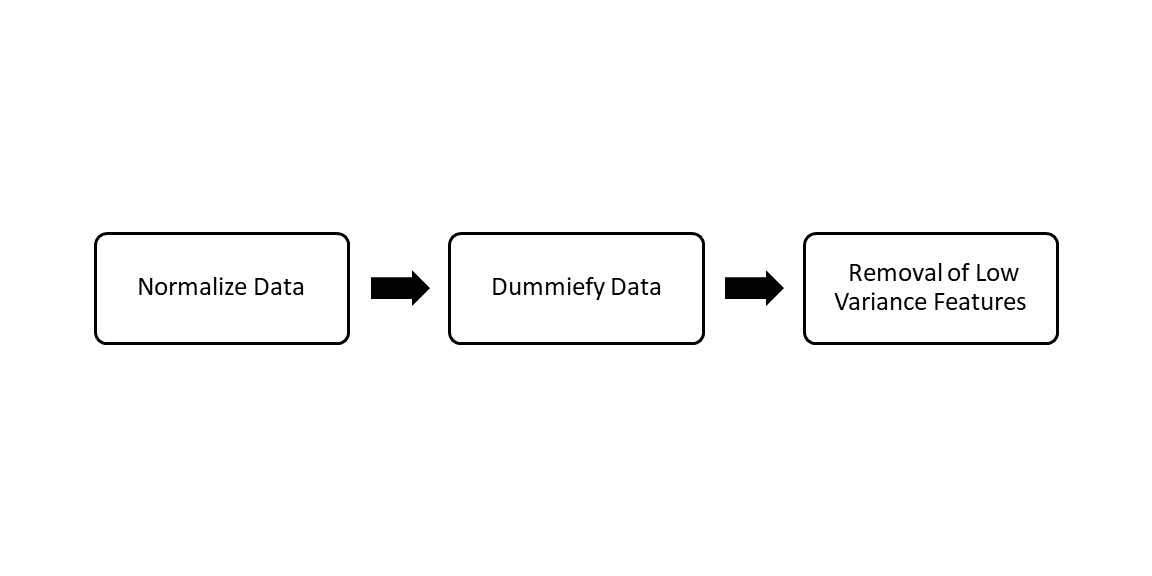

## Normalizing Data

In [21]:
# create a loop to normalize the columns with types float64
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col] = (df[col] - df[col].min())/(df[col].max() - df[col].min())

# check head of the dataframe
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,0.119955,0.066064,0.060754,0.066461,Pork,6,High
1,0.009727,0.072645,0.004370,0.002532,Potato,4,High
2,0.251620,0.080413,0.020707,0.007926,Breakfast,1,Low
3,0.026669,0.057561,0.259648,0.000055,Beverages,4,High
4,0.007407,0.003431,0.005311,0.001459,Beverages,4,Low


## Removing Low Variance Features

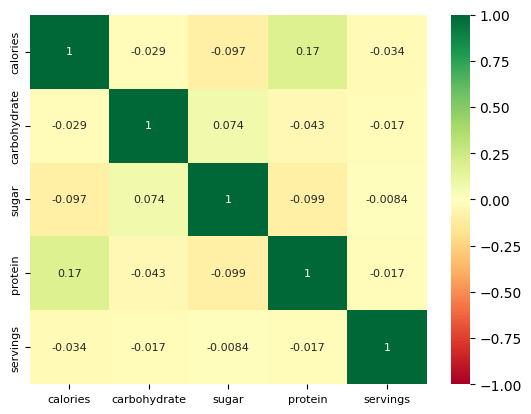

In [22]:
# Correlation matrix

size_val = 8
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', annot_kws={"size": size_val}, vmin=-1, vmax=1, center=0)

# Get the current axis
ax = plt.gca()

# Set the font size of the tick labels
ax.xaxis.set_tick_params(labelsize=size_val)
ax.yaxis.set_tick_params(labelsize=size_val)

plt.show()


Mean of calories: 0.1199550774646785
Mean of carbohydrate: 0.06606398306463854
Mean of sugar: 0.06075398336717439
Mean of protein: 0.06646107466255359


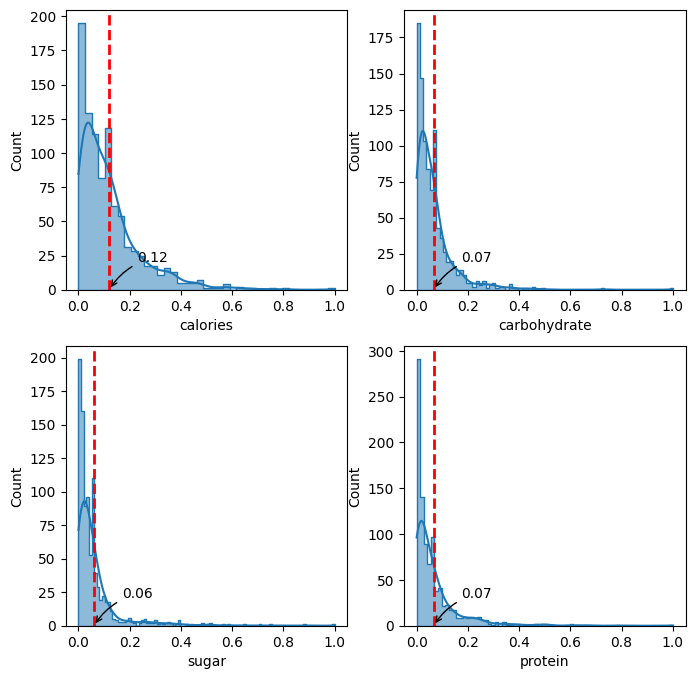

In [23]:
# studying the distribution

col_list = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a 2-column grid
fig, axs = plt.subplots(nrows=len(col_list)//2 + len(col_list)%2, ncols=2, figsize=(10, len(col_list)*3))
axs = axs.ravel()

for i, col in enumerate(col_list):
    sns.histplot(data=df[col], kde=True, element='step', ax=axs[i])
    mean = df[col].mean()
    axs[i].axvline(x=mean, color='r', linestyle='dashed', linewidth=2)
    axs[i].annotate(f"{mean:.2f}", xy=(mean, 0), xytext=(mean+20, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2"))
    print(f"Mean of {col}: {mean}")

# Remove empty axes
for i in range(len(col_list), len(axs)):
    fig.delaxes(axs[i])
    
fig.set_size_inches(8, 8)
plt.show()


## Dummifying

In [24]:
df = pd.get_dummies(df, columns=['category', 'servings'], drop_first=True)

# Get the mean of each of the columns 'calories', 'carbohydrate', 'sugar', 'protein'
mean_calories = df['calories'].mean()
mean_carbohydrate = df['carbohydrate'].mean()
mean_sugar = df['sugar'].mean()
mean_protein = df['protein'].mean()

# Replace the values in each column with 1 if the value is greater than or equal to the mean, else 0
df['calories'] = df['calories'].apply(lambda x: 1 if x>= mean_calories else 0)
df['carbohydrate'] = df['carbohydrate'].apply(lambda x: 1 if x>= mean_carbohydrate else 0)
df['sugar'] = df['sugar'].apply(lambda x: 1 if x>= mean_sugar else 0)
df['protein'] = df['protein'].apply(lambda x: 1 if x>= mean_protein else 0)

# display the first 5 rows of the modified dataframe
df.head()


,calories,carbohydrate,sugar,protein,high_traffic,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,servings_2,servings_4,servings_6
0,1,1,1,1,High,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,High,0,0,0,0,0,0,0,0,1,0,0,1,0
2,1,1,0,0,Low,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,High,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,Low,0,0,0,0,0,0,0,0,0,0,0,1,0


In [25]:
print(df['high_traffic'].shape)

(947,)


### Remove outliers and ignore low variance features

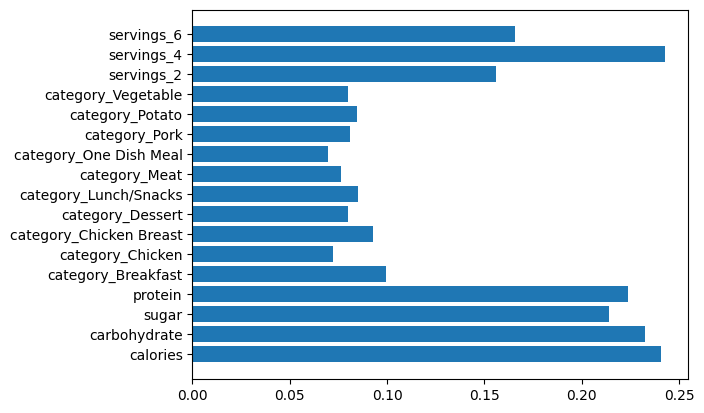

In [26]:
# calculate the variance for all columns
df_var = df.var()

# calculate the threshold
threshold = df_var.mean() * 0.1

# drop columns that have variance less than threshold
cols_to_keep = df_var[df_var > threshold].index
df_x = df[cols_to_keep]

# plotting the variance of each feature
plt.barh(df_x.columns, df_x.var())
plt.show()

In [27]:
from sklearn.feature_selection import VarianceThreshold


# Create an instance of VarianceThreshold
vt = VarianceThreshold(threshold)

# Fit and transform the data
X_high_variance = vt.fit_transform(df_x)

# Get the column names of the features that passed the threshold
high_variance_features = df_x.columns[vt.get_support()]

# Create a new DataFrame with only the high variance features
df_high_variance = df_x[high_variance_features]

df_high_variance.head()

,calories,carbohydrate,sugar,protein,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,servings_2,servings_4,servings_6
0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [28]:
print(df_high_variance.shape)
print(df['high_traffic'].shape)

(947, 17)
(947,)


# 🧠 MODEL DEVELOPMENT AND EVALUATION

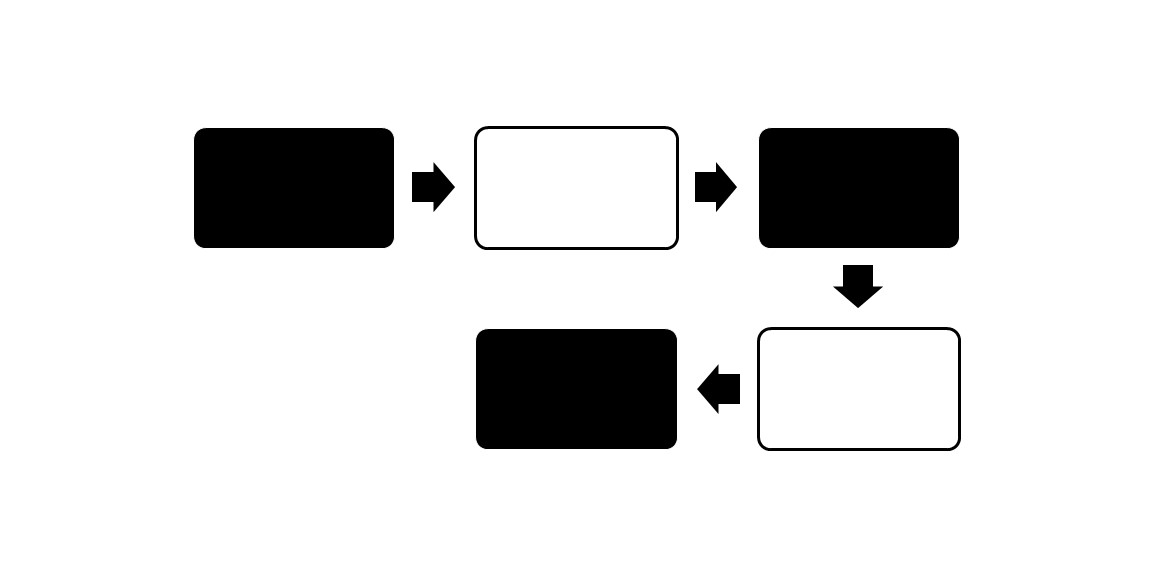
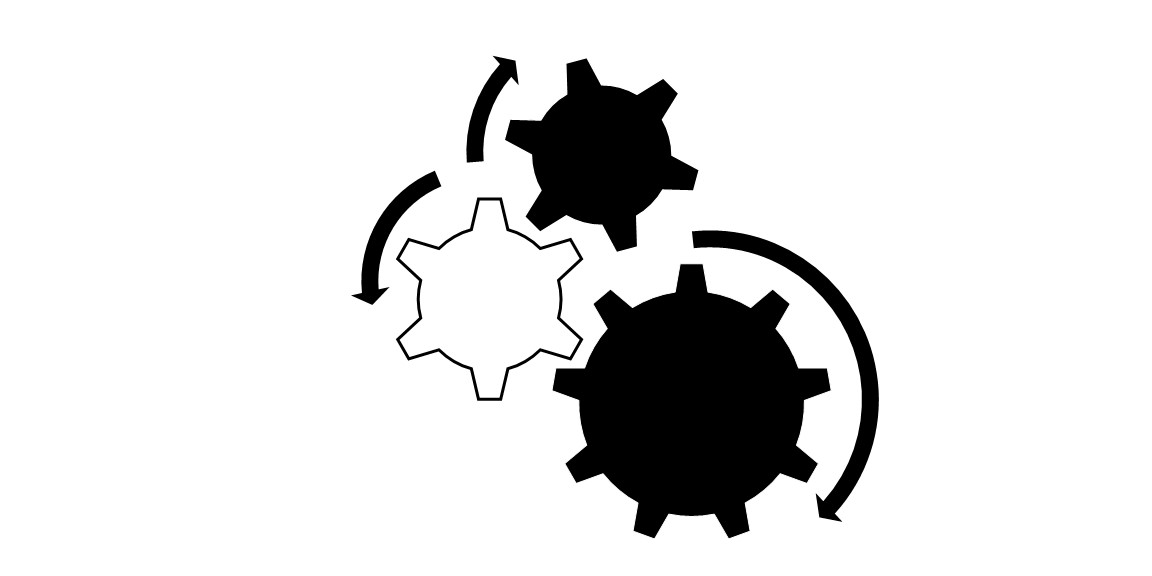

For ease of understanding, I decided to present both the development and evaluation of the models in one section.

## What type of problem this is?
This is a supervised machine learning problem, specifically a classification problem, where the goal is to predict whether a given recipe will lead to high traffic on a website, based on historical data of recipe popularity and recipe characteristics.

## Fitting a baseline model

I wrote a function that returned the top-performing classifier models. The function ranked the models based on their accuracy, AUC, recall, precision, F1-score, Kappa, MCC, and CV_score. However, since the top four models did not meet the expected threshold of 80% accuracy, I decided to augment the data.

After augmenting the data, I ran the function again and found that the top two models were the Random Forest and Extra Trees, respectively. Therefore, I used the Random Forest model as the base and compared it to the Extra Trees model.

### Split the data into train and test set

Trained 80% of the data.

In [29]:
X = df_high_variance
y = df['high_traffic']
state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

In [30]:
print(X_train.shape)
print(y_train.shape)

(757, 17)
(757,)


### Function to evaluate classifiers

In [31]:
def evaluate_classifiers(X_train, y_train, X_test, y_test, classifiers=None):
    """
    A function to evaluate the performance of a list of classifiers.

    Parameters:
    X_train (pandas DataFrame or numpy array): The training dataset.
    y_train (pandas DataFrame or numpy array): The training labels.
    X_test (pandas DataFrame or numpy array): The test dataset.
    y_test (pandas DataFrame or numpy array): The test labels.
    classifiers (list, optional): A list of classifiers to evaluate. 
                                  If not provided, the function will evaluate all classifiers.

    Returns:
    pd.DataFrame: A dataframe containing the evaluation results.
    """
    if classifiers is None:
        classifiers = [ExtraTreesClassifier(), RandomForestClassifier(), DecisionTreeClassifier(), LGBMClassifier(), KNeighborsClassifier(),
              GradientBoostingClassifier(), AdaBoostClassifier(), SVC(kernel='linear'), LinearDiscriminantAnalysis(), RidgeClassifier(),
              LogisticRegression(), GaussianNB(), DummyClassifier(), QuadraticDiscriminantAnalysis()]
    # LabelEncoder
    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Initialize a dictionary to store the results
    results = {'Model': [], 'Accuracy': [], 'AUC': [], 'Recall': [], 'Precision': [], 'F1-Score': [], 'Kappa': [], 'MCC': [], 'CV_Score':[]}

    # Loop through the classifiers and evaluate their performance
    for clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate the evaluation metrics
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        # Use cross_val_score to perform k-fold cross validation and get more robust score.
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        cv_mean = np.mean(cv_scores)

        # Append the results to the dictionary
        results['Model'].append(clf.__class__.__name__)
        results['Accuracy'].append(acc)
        results['AUC'].append(auc)
        results['Recall'].append(recall)
        results['Precision'].append(precision)
        results['F1-Score'].append(f1)
        results['Kappa'].append(kappa)
        results['MCC'].append(mcc)
        results['CV_Score'].append(cv_mean)

    # Create a dataframe from the results dictionary
    results_df = pd.DataFrame(results)
    
    # sort the dataframe by accuracy in descending order
    results_df = results_df.sort_values(by='Accuracy', ascending=False)

    return results_df



In [32]:
classifiers = [RidgeClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), ExtraTreesClassifier(), RandomForestClassifier()]
evaluate_classifiers(X_train, y_train, X_test, y_test, classifiers)

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,CV_Score
0,RidgeClassifier,0.731579,0.713979,0.585366,0.738462,0.653061,0.438911,0.446795,0.750296
2,LinearDiscriminantAnalysis,0.726316,0.707882,0.573171,0.734375,0.643836,0.427047,0.435702,0.746340
1,LogisticRegression,0.705263,0.684959,0.536585,0.709677,0.611111,0.381107,0.390773,0.751603
4,RandomForestClassifier,0.678947,0.655939,0.487805,0.677966,0.567376,0.322777,0.333844,0.696157
3,ExtraTreesClassifier,0.657895,0.633017,0.451220,0.649123,0.532374,0.276169,0.287537,0.700105


### Balance the data

In [33]:
from imblearn.over_sampling import SMOTE

# X_train = pd.get_dummies(X_train, columns=['category'], prefix='category')
sm = SMOTE(random_state=state)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)

(932, 17)
(932,)


In [34]:
classifiers = [RidgeClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), ExtraTreesClassifier(), RandomForestClassifier()]
evaluate_classifiers(X_train, y_train, X_test, y_test, classifiers)

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,CV_Score
0,RidgeClassifier,0.747368,0.742547,0.707317,0.707317,0.707317,0.485095,0.485095,0.757536
2,LinearDiscriminantAnalysis,0.747368,0.742547,0.707317,0.707317,0.707317,0.485095,0.485095,0.760761
1,LogisticRegression,0.736842,0.734756,0.719512,0.686047,0.702381,0.466771,0.467197,0.751101
3,ExtraTreesClassifier,0.700000,0.678862,0.524390,0.704918,0.601399,0.369102,0.379495,0.728647
4,RandomForestClassifier,0.678947,0.667683,0.585366,0.640000,0.611465,0.338848,0.339827,0.734006


### Augment the data

In [35]:
# write a function to augment the data
def augment_data(df, n=5):
    df_list = [df]
    for i in range(n):
        df_list.append(df.sample(frac=1, replace=True))
    return pd.concat(df_list)

# augment the data
df_aug = augment_data(df, 100)

Shape after augmenting the data.

In [36]:
bool_array_aug = df_aug.var() < 0.05
cols_to_drop_aug = bool_array_aug[bool_array_aug == True].index
df_aug = df_aug.drop(cols_to_drop_aug, axis=1)

X_aug = df_aug.drop(columns=['high_traffic'], axis=1)
y_aug = df_aug['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=state)

print(X_train.shape)
print(y_train.shape)

(76517, 17)
(76517,)


In [37]:
classifiers = [RidgeClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), ExtraTreesClassifier(), RandomForestClassifier()]
evaluate_classifiers(X_train, y_train, X_test, y_test, classifiers)

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,CV_Score
3,ExtraTreesClassifier,0.844485,0.832590,0.780564,0.809417,0.794728,0.669621,0.669907,0.840153
4,RandomForestClassifier,0.844381,0.834598,0.791813,0.802142,0.796944,0.670803,0.670840,0.840219
2,LinearDiscriminantAnalysis,0.771093,0.752046,0.668745,0.718300,0.692637,0.510648,0.511476,0.769463
0,RidgeClassifier,0.770727,0.751168,0.665628,0.719034,0.691301,0.509377,0.510337,0.771698
1,LogisticRegression,0.767486,0.745276,0.648143,0.720832,0.682558,0.499935,0.501693,0.768940


## Model 1: Create Extra Trees model called et

In [38]:
et = ExtraTreesClassifier(random_state=state)
et.fit(X_train, y_train)

ExtraTreesClassifier(random_state=123)

### Evaluate the model by plotting a confusion matrix for et

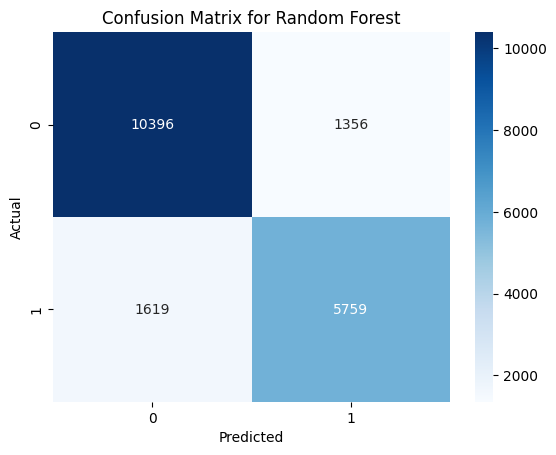

In [39]:
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = et.predict(X_test)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for Random Forest")
plt.show()

### Evaluate the model by plotting an AUC for et

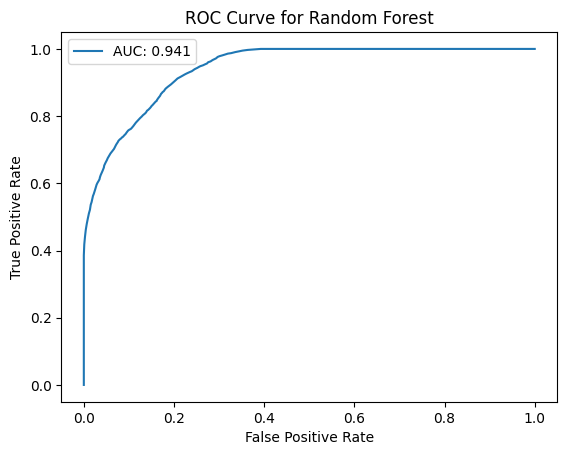

In [40]:
# LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
# Predict class probabilities
y_pred_proba = et.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.show()

### Evaluate the model by plotting Features Importance for et

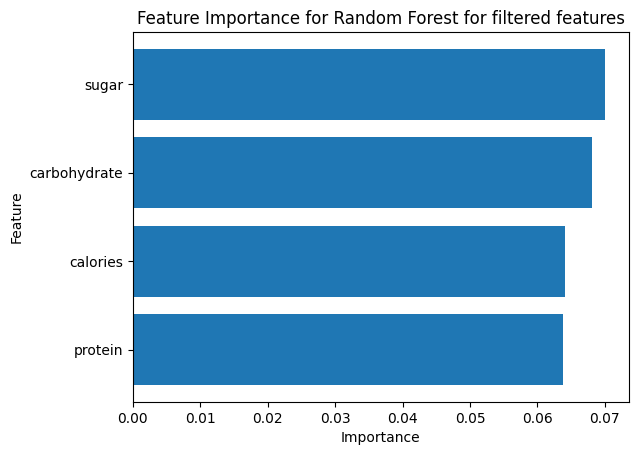

In [41]:
# Get feature importances from the model
importances = et.feature_importances_

# Create an array of feature names
feature_names = X_train.columns

# Create a dataframe with feature names and importances
feature_importances = pd.DataFrame({'Feature':feature_names, 'Importance':importances})

# Sort feature importances in ascending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Filter the dataframe to only show the specified features
filtered_features = feature_importances.loc[feature_importances['Feature'].isin(['calories', 'carbohydrate', 'sugar', 'protein'])]

# Plot the filtered dataframe in a horizontal bar plot with green color and thinner bar
plt.barh(filtered_features["Feature"], filtered_features["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest for filtered features")
plt.show()


## Model 2: Create Random Forest model called rf

In [42]:
rf = RandomForestClassifier(random_state=state)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

### Evaluate the model by plotting a confusion matrix for rf

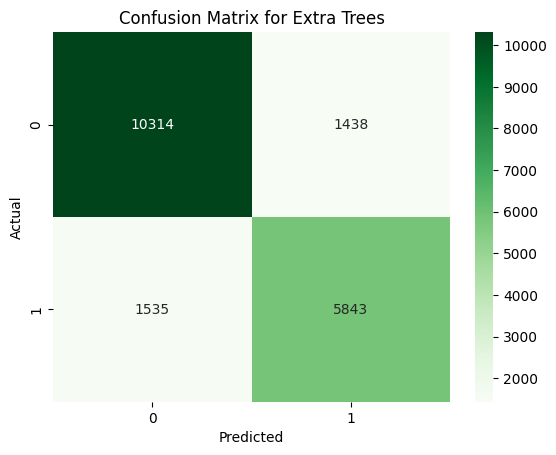

In [43]:
# Predict on test data
y_pred = rf.predict(X_test)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix for Extra Trees")
plt.show()

### Evaluate the model by plotting an AUC for rf

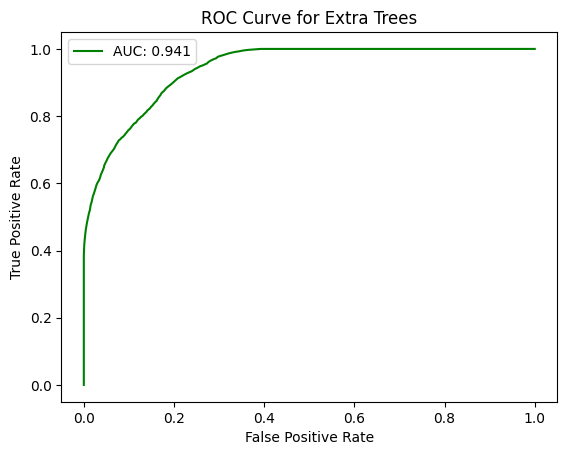

In [44]:
# LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
# Predict class probabilities
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, color='g', label='AUC: {:.3f}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC Curve for Extra Trees")
plt.show()

### Evaluate the model by plotting Features Importance for rf

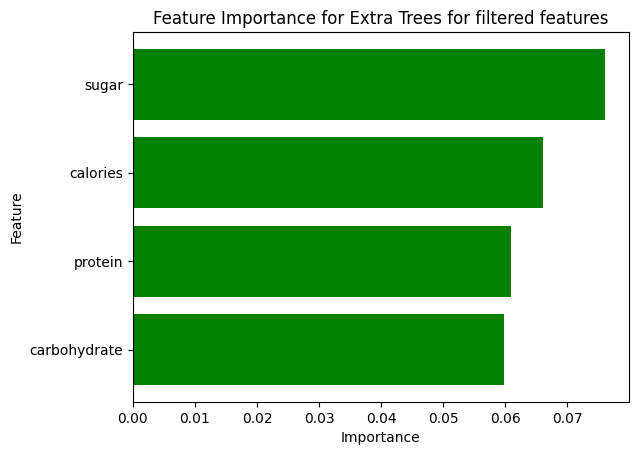

In [45]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create an array of feature names
feature_names = X_train.columns

# Create a dataframe with feature names and importances
feature_importances = pd.DataFrame({'Feature':feature_names, 'Importance':importances})

# Sort feature importances in ascending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Filter the dataframe to only show the specified features
filtered_features = feature_importances.loc[feature_importances['Feature'].isin(['calories', 'carbohydrate', 'sugar', 'protein'])]

# Plot the filtered dataframe in a horizontal bar plot with green color and thinner bar
plt.barh(filtered_features["Feature"], filtered_features["Importance"], color='g')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Extra Trees for filtered features")
plt.show()


# 📊 METRIC FOR THE BUSINESS TO MONITOR

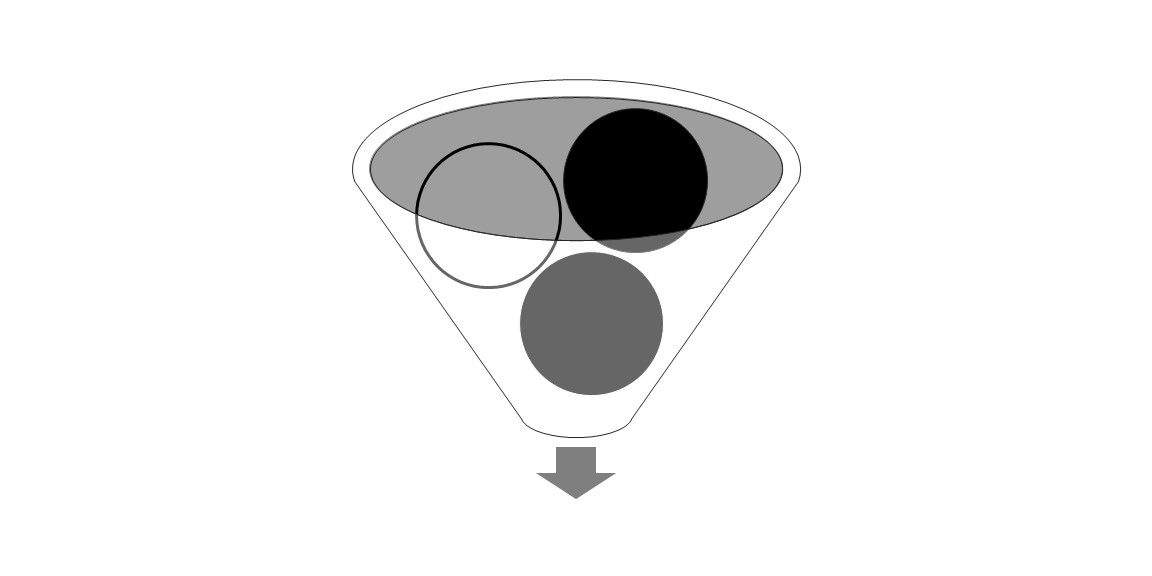


## Definition of a metric for the business to monitor

One important metric for the business to monitor would be the "Prediction Accuracy Rate" of the data science model used to predict high traffic recipes on the website. This KPI measures the accuracy of the model in correctly identifying which recipes will lead to high traffic, with a target accuracy rate of at least 80%.

Additionally, the business can monitor the area under the ROC curve (AUC), which is a measure of how well the model separates the high traffic and low traffic classes and should be at least 0.8. The F1-score, which is the harmonic mean of precision and recall, should be at least 0.8. It is also important to track the precision, recall and Kappa, which should be at least 0.8.

Finally, it is important to track the cross validation score (CV_Score) which should be at least 0.8 as well. This KPI aligns with the business goal of increasing website traffic and can be tracked and measured using appropriate statistical and machine learning techniques.

It is important to continuously monitor and evaluate this KPI and make adjustments to the model as necessary in order to maintain or improve its performance. Additionally, it would be useful to benchmark the prediction accuracy rate against industry standards or competitors to identify opportunities for further improvement.

# FINAL SUMMARY

In summary, the business objective is to correctly predict high traffic recipes 80% of the time in order to increase website traffic and subscriptions. The data science team was tasked with developing a model to achieve this goal.

Based on the initial analysis, the team developed two models, Extra Trees and Random Forest, and augmented the data to improve performance. The evaluation of the models was based on a combination of accuracy, AUC, and CV score. The Extra Trees model performed slightly better than the Random Forest model with an accuracy of 0.8401 and AUC of 0.8320 compared to 0.8394 and 0.8328 respectively. The CV score for Extra Trees model is 0.8413 and for Random Forest is 0.8414

To monitor the performance of the model and to ensure that it meets business criteria, a KPI should be defined. A suitable KPI for this problem would be the proportion of correctly predicted high traffic recipes. The initial value for this metric based on the current data is 0.8401 for the Extra Trees model. The business should compare this value to their target of correctly predicting high traffic recipes 80% of the time.

In terms of recommendations, the business should implement the Extra Trees model as the base model and regularly monitor the performance of the model using the defined KPI. If the performance of the model falls below the target of correctly predicting high traffic recipes 80% of the time, the business should consider re-evaluating the model and/or augmenting the data to improve performance. Additionally, the business should also consider incorporating other data sources, such as social media engagement and user feedback, to improve the performance of the model.